# Body-fata dataset

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import  TensorDataset
import results.precise_kernel.process_results as process_results

2023-07-23 12:17:44.328231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def csv_to_pth(name, csv_path, pth_path):
    def dataframe_to_arrays(df):
        df_ = df.copy(deep=True)
        X = np.atleast_2d(df_[input_cols].to_numpy())
        Y = np.atleast_2d(df_[output_cols].to_numpy().reshape(-1,1))
        return X, Y
    dataframe_raw = pd.read_csv(csv_path, delimiter=',').iloc[:, 1:]
    dataframe_raw = dataframe_raw[dataframe_raw['BodyFat'] > 0] # Drop sample with BodyFat == 0
    input_cols = list(dataframe_raw.columns)[1:]
    output_cols = list(dataframe_raw.columns)[0]
    X, Y = dataframe_to_arrays(dataframe_raw)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    inputs = torch.tensor(X, dtype=torch.float64)
    targets = torch.tensor(Y, dtype=torch.float64)
    torch.save([inputs, targets], pth_path + name + '.pth')
    return input_cols, output_cols
input_cols, output_cols = csv_to_pth("bodyfat", "data/bodyfat.csv", "data/")

In [3]:
def create_dataset(dataset, static, fold):
    dataset_path = ('./data/' + dataset + '.pth')
    dataset = TensorDataset(*torch.load(dataset_path))
    X, Y = dataset.tensors
    X, Y = X.numpy(), Y.numpy()

    if static == False:
        Y_mean, Y_std = Y.mean(0), Y.std(0) + 1e-9
        #Y = (Y - Y_mean) / Y_std
        return X, Y, Y_mean, Y_std
    else:
        X_train_indices_boolean = np.random.choice([1, 0], size=X.shape[0], p=[0.8, 0.2])
        X_train_indices = np.where(X_train_indices_boolean == 1)[0]
        X_test_indices = np.where(X_train_indices_boolean == 0)[0]
        X_train = X[X_train_indices]
        Y_train = Y[X_train_indices]
        X_test = X[X_test_indices]
        Y_test = Y[X_test_indices]
        Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
        Y_train = (Y_train - Y_train_mean) / Y_train_std
        Y_test = (Y_test - Y_train_mean) / Y_train_std
        return X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std, X_train_indices, X_test_indices

In [4]:
X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std, _, _ = create_dataset('bodyfat', True, 0)

In [3]:
!rm -rf results/run*
!python3 run_regression.py --dataset boston --iterations 256 --num_posterior_samples 256 --n_layers 1 --precise_kernel 1 --kfold -1 --prior_precision_type matrixinvwishart

zsh:1: no matches found: results/run*



### Static Train/Test split ###
INFO:root:Loading dataset from ./data/boston.pth
INFO:root:Number of inducing points: 100
================= DGP
 Input dim = 13
 Output dim = 1
 Depth = 1
 |============ GP Layer 
 | Input dim = 13
 | Output dim = 1
 | Num inducing = 100
 | Prior on inducing positions = normal
 | |======= Kernel: FullPrecisionRBF (param: LLᵀ)
 | | Variance = 0.100
 | | Prior precision type = matrixinvwishart
TRAIN | iter =      1      sample marginal LL = -2.11
TRAIN | iter =    251      sample marginal LL = -3.36
{'dataset': 'boston',
 'fold': 0,
 'minibatch_size': 407,
 'model': 'bsgp',
 'n_layers': 1,
 'num_inducing': 100,
 'precise_kernel': 1,
 'prior_type': 'normal',
 'test_mnll': 2.7478157333674247}


In [4]:
processed_results_onefold = process_results.process_results_onefold(filepath='results/run-0001/LRBF_results.json', precise_kernel=1, d=13)

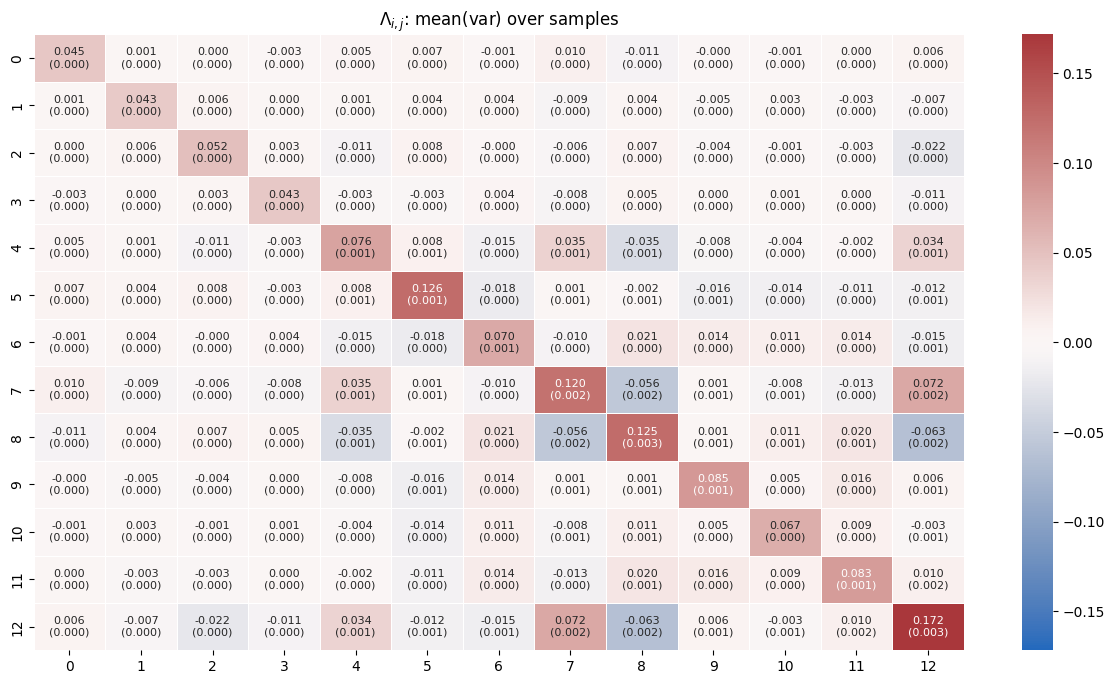

In [5]:
process_results.heatmap_precision(processed_results_onefold['precisions_merged_mean'], processed_results_onefold['precisions_merged_var'], fig_height=8, fig_width=15)

In [13]:
np.sum(processed_results_onefold['precisions_merged_mean'] > 10e4)

2

In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()
input_dim = 3
output_dim = 3

mean_matrix = tf.zeros((input_dim, output_dim), dtype=tf.float32)
covariance_matrix_row = tfp.util.TransformedVariable(
    initial_value=tf.eye(input_dim),
    bijector=tfp.bijectors.FillScaleTriL(),
    name='covariance_matrix_row',
    dtype=tf.float32)

covariance_matrix_col = tfp.util.TransformedVariable(
    initial_value=tf.eye(output_dim),
    bijector=tfp.bijectors.FillScaleTriL(),
    name='covariance_matrix_col',
    dtype=tf.float32)

# Create Linear Operators from the covariance matrices
linear_operator_row = tf.linalg.LinearOperatorLowerTriangular(
    covariance_matrix_row)

linear_operator_col = tf.linalg.LinearOperatorLowerTriangular(
    covariance_matrix_col)

# Create the MatrixNormalLinearOperator
matrix_normal_distribution = tfp.distributions.MatrixNormalLinearOperator(
    loc=mean_matrix,
    scale_row=linear_operator_row,
    scale_column=linear_operator_col
)

In [7]:
P  = tf.random.normal((3,3), dtype=tf.float32)
P =  tf.linalg.matmul(P, tf.transpose(P))
matrix_normal_distribution.log_prob(P).to_dense()

AttributeError: 'Tensor' object has no attribute 'to_dense'

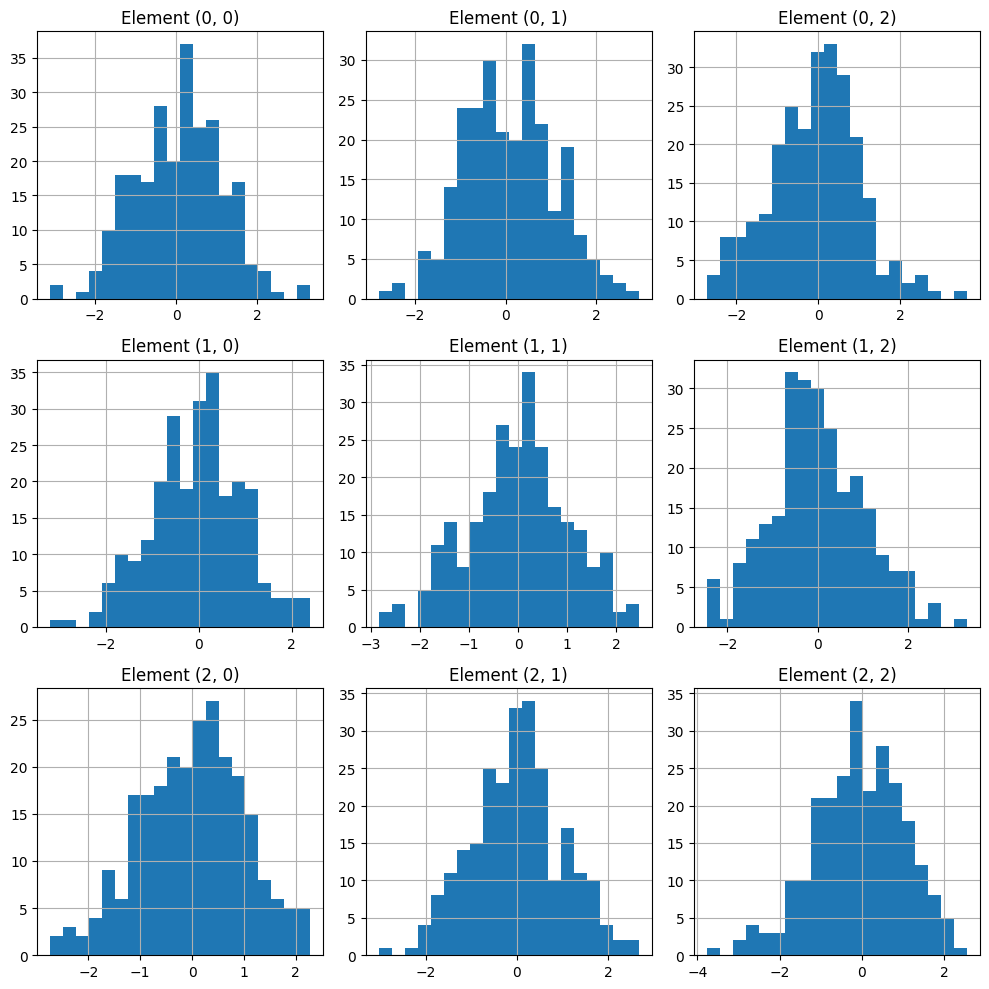

In [14]:
samples = matrix_normal_distribution.sample(250)
sampled_elements = np.array(samples)

# Plot the distribution of each element of the 3x3 matrix
fig, axes = plt.subplots(input_dim, output_dim, figsize=(10, 10))

for i in range(input_dim):
    for j in range(output_dim):
        axes[i, j].hist(sampled_elements[:, i, j], bins=20)
        axes[i, j].set_title(f'Element ({i}, {j})')
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
tf.math.reduce_sum(tf.math.log(tf.linalg.tensor_diag_part(tf.math.maximum(tf.cast(1e-8, tf.float64), tf.math.abs(L))))) - tf.linalg.trace(1/model.n*tf.eye(model.n, dtype = tf.float64)@P) / 2
